In [72]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sector_etfs = ['XLE', 'XLF', 'XLK', 'XLI', 'XLB', 'XLV', 'XLY', 'XLP', 'XLU', 'XLRE'] # Add XLC, XLRE?
sector_twin_etfs = [
    'XLF', 'VFH',   # Financials
    'XLK', 'VGT',   # Tech
    'XLY', 'VCR',   # Consumer Discretionary
    'XLP', 'VDC',   # Consumer Staples
    'XLV', 'VHT',   # Healthcare
    'XLE', 'VDE',   # Energy
    'XLI', 'VIS',   # Industrials
    'XLB', 'VAW',   # Materials
    'XLU', 'VPU',   # Utilities
    'XLRE', 'VNQ',  # Real Estate
    'VOX',   # Comms without XLC
]
dividend_etfs = ['VYM', 'HDV', 'SCHD', 'DVY']
bond_etfs = ['SHY', 'VGSH', 'IEF', 'TLH', 'TLT', 'SPTL']
industry_etfs = ['KBE', 'XOP', 'IHF', 'SOXX', 'ITA', 'IBB']
thematic_etfs = ['ARKK', 'ARKW', 'ROBO', 'BOTZ', 'TAN', 'ICLN', 'LIT'] # Add BATT?
international_etfs = ['EFA', 'VEA', 'IEMG', 'EEM', 'EWJ', 'EWU', 'EWG', 'FXI', 'EWZ']

etf_categories = {
    'sector': sector_etfs,
    'sector_twins': sector_twin_etfs,
    'dividend': dividend_etfs,
    'bond': bond_etfs,
    'industry_etfs': industry_etfs,
    'thematic': thematic_etfs,
    'international': international_etfs
}

flattened_etfs = [etf for etfs in etf_categories.values() for etf in etfs]

prices = yf.download(flattened_etfs, start = '2015-01-01', end = '2020-01-01')['Close']

for etf in prices.columns:
    data = prices[etf]

    if data.empty:
        print(f"{etf} does not contain data")

# Pearson correlation

for category, etfs in etf_categories.items():
    desired_etfs = [etf for etf in etfs]

    category_prices = prices[desired_etfs]

    returns = category_prices.pct_change().dropna()

    correlation_matrix = returns.corr()
    correlation_matrix = correlation_matrix.rename_axis(None).rename_axis(None, axis = 1)
    correlation_matrix = correlation_matrix.stack().reset_index()
    correlation_matrix.columns = ['ETF', 'Pair', 'Correlation']

    correlation_matrix =  correlation_matrix[correlation_matrix['ETF'] != correlation_matrix['Pair']]
    correlation_matrix = correlation_matrix.sort_values(by = 'Correlation', ascending = False)
    correlation_matrix = correlation_matrix.drop_duplicates('Correlation')

    potential_pairs = correlation_matrix[correlation_matrix['Correlation'] > 0.8]

    print(f"Potential Correlated Pairs from {category}:")
    print(potential_pairs)

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_58046/3439949594.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(flattened_etfs, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  53 of 53 completed


Potential Correlated Pairs from sector:
    ETF Pair  Correlation
26  XLK  XLY     0.847598
34  XLI  XLB     0.833963
31  XLI  XLF     0.803181
Potential Correlated Pairs from sector_twins:
      ETF Pair  Correlation
221   XLE  VDE     0.995401
373   VPU  XLU     0.993254
153   VDC  XLP     0.992814
21    VFH  XLF     0.992746
65    VGT  XLK     0.992254
109   VCR  XLY     0.991973
265   XLI  VIS     0.991683
177   XLV  VHT     0.988897
309   XLB  VAW     0.984737
397  XLRE  VNQ     0.932005
328   VAW  VIS     0.866973
108   VCR  VGT     0.853570
47    XLK  VCR     0.849227
87    XLY  VGT     0.848932
327   VAW  XLI     0.848783
86    XLY  XLK     0.847598
287   VIS  XLB     0.843426
306   XLB  XLI     0.833963
118   VCR  VIS     0.825219
34    VFH  VIS     0.823861
273   VIS  XLF     0.818526
97    XLY  VIS     0.808991
33    VFH  XLI     0.803347
12    XLF  XLI     0.803181
257   XLI  VCR     0.802492
Potential Correlated Pairs from dividend:
     ETF  Pair  Correlation
2    VYM  SC

In [73]:
# checking data point count
etf_data_counts = prices.notna().sum().sort_values()

etf_data_coverage = etf_data_counts.to_frame(name='Available Days')
etf_data_coverage.index.name = 'ETF'

print(etf_data_coverage.head(10)) 

      Available Days
ETF                 
BOTZ             831
XLRE            1065
ARKW            1258
ARKK            1258
EEM             1258
EFA             1258
EWG             1258
DVY             1258
EWU             1258
EWZ             1258


In [74]:
# cointegration

for category, etfs in etf_categories.items():

        candidate_pairs = []

        desired_etfs = [etf for etf in etfs]

        category_prices = prices[desired_etfs]

        for i in range(len(desired_etfs)):
                for j in range(i + 1, len(desired_etfs)):
                        candidate_pairs.append([desired_etfs[i], desired_etfs[j]])

        cointegrated_pairs = []

        for etf1, etf2 in candidate_pairs:

                df = category_prices[[etf1, etf2]].dropna()

                s_etf1 = df[etf1]
                s_etf2 = df[etf2]

                score, pvalue, _ = coint(s_etf1, s_etf2)

                if pvalue < 0.05:
                        cointegrated_pairs.append((etf1, etf2, pvalue))
                        
        cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs, columns = ['ETF', 'Pair', 'P-Value'])
        cointegrated_pairs_df = cointegrated_pairs_df.sort_values('P-Value').reset_index(drop=True)

        print(f"Cointegration Test Results for {category}:")
        print(cointegrated_pairs_df)

Cointegration Test Results for sector:
   ETF  Pair   P-Value
0  XLP   XLU  0.004866
1  XLU  XLRE  0.009153
2  XLF   XLI  0.046023
Cointegration Test Results for sector_twins:
    ETF  Pair   P-Value
0   VDC   XLU  0.001800
1   XLP   XLU  0.004866
2   VDC   VPU  0.005018
3   XLU  XLRE  0.009153
4   XLP   VPU  0.014920
5   XLU   VNQ  0.017298
6   VFH   VIS  0.018925
7   VPU  XLRE  0.019214
8   VGT   XLV  0.024441
9   VGT   VCR  0.026695
10  XLF   VIS  0.028482
11  VGT   XLY  0.031965
12  VDC   VNQ  0.032836
13  VFH   XLI  0.033239
14  VPU   VNQ  0.033254
15  XLP   VNQ  0.033524
16  VGT   VHT  0.042915
17  XLF   XLI  0.046023
18  VDC  XLRE  0.048871
19  VFH   XLB  0.049988
Cointegration Test Results for dividend:
Empty DataFrame
Columns: [ETF, Pair, P-Value]
Index: []
Cointegration Test Results for bond:
   ETF  Pair   P-Value
0  IEF   TLH  0.014436
1  TLT  SPTL  0.015322
Cointegration Test Results for industry_etfs:
Empty DataFrame
Columns: [ETF, Pair, P-Value]
Index: []
Cointegration T

In [75]:
# rolling cointegration

window_size = 252
min_passes = 0.3
step = 21

for category, etfs in etf_categories.items():

    candidate_pairs = []
    rolling_cointegrated_pairs = []

    desired_etfs = [etf for etf in etfs]

    category_prices = prices[desired_etfs]

    for i in range(len(desired_etfs)):
        for j in range(i + 1, len(desired_etfs)):
                candidate_pairs.append([desired_etfs[i], desired_etfs[j]])

    for etf1, etf2 in candidate_pairs:
            
        df = category_prices[[etf1, etf2]].dropna()

        s_etf1 = df[etf1]
        s_etf2 = df[etf2]

        df = pd.concat([s_etf1, s_etf2], axis = 1)

        if len(df[etf1]) == 0:
            print(f"{etf1} does not have sufficient data")
            continue
        elif len(df[etf2]) == 0:
            print(f"{etf2} does not have sufficient data")
            continue
            
        series1 = df.iloc[:, 0]
        series2 = df.iloc[:, 1]

        cointegrated_windows = 0
        total_windows = 0

        for start in range(0, len(df) - window_size + 1, step):
            end = start + window_size

            window_s1 = series1.iloc[start:end]
            window_s2 = series2.iloc[start:end]
                
            score, pvalue, _ = coint(window_s1, window_s2)
            total_windows += 1
                
            if pvalue < 0.1:
                cointegrated_windows += 1

        if cointegrated_windows / total_windows >= min_passes:
            rolling_cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})


    rolling_cointegrated_pairs_df = pd.DataFrame(rolling_cointegrated_pairs)

    if rolling_cointegrated_pairs_df.empty:
        print(f"{category} has no rolling cointegrated pairs.")
        continue
    else:
        rolling_cointegrated_pairs_df = rolling_cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop=True)
        print(f"Rolling Cointegration Test Results for {category}:")
        print(rolling_cointegrated_pairs_df)

Rolling Cointegration Test Results for sector:
  ETF1  ETF2    Pass %
0  XLV   XLU  0.458333
1  XLP   XLU  0.416667
2  XLV  XLRE  0.384615
3  XLI   XLB  0.354167
4  XLB   XLY  0.354167
5  XLU  XLRE  0.307692
Rolling Cointegration Test Results for sector_twins:
   ETF1  ETF2    Pass %
0   XLV   XLU  0.458333
1   XLV   VPU  0.458333
2   VDC   XLU  0.437500
3   VDC   VPU  0.437500
4   XLP   XLU  0.416667
5   VIS   VAW  0.416667
6   VCR   XLB  0.416667
7   VPU  XLRE  0.410256
8   VHT   XLU  0.395833
9   XLP   VPU  0.395833
10  XLV  XLRE  0.384615
11  VHT   VPU  0.375000
12  VIS   XLB  0.354167
13  XLI   XLB  0.354167
14  XLF   VFH  0.333333
15  XLY   XLB  0.333333
16  XLU  XLRE  0.307692
Rolling Cointegration Test Results for dividend:
   ETF1 ETF2    Pass %
0   VYM  DVY  0.375000
1  SCHD  DVY  0.354167
Rolling Cointegration Test Results for bond:
  ETF1  ETF2    Pass %
0  SHY  VGSH  0.583333
1  TLT  SPTL  0.416667
Rolling Cointegration Test Results for industry_etfs:
   ETF1 ETF2  Pass %


In [76]:
# adf test / z-score spread

def zscore_calc(series):
    return (series - series.mean()) / series.std()

def adf_test(series):
    test_res = adfuller(series)
    return {'stat': test_res[0], 'p-value': test_res[1]}

def hedge_ratio_calc(series1, series2):
    x = sm.add_constant(series2)
    model = sm.OLS(series1, x).fit()

    return model.params.iloc[1]


for category, etfs in etf_categories.items():

    candidate_pairs = []
    rolling_cointegrated_pairs = []
    results = []

    desired_etfs = [etf for etf in etfs]

    category_prices = prices[desired_etfs]

    for i in range(len(desired_etfs)):
        for j in range(i + 1, len(desired_etfs)):
                candidate_pairs.append([desired_etfs[i], desired_etfs[j]])

    for etf1, etf2 in candidate_pairs:

        df = category_prices[[etf1, etf2]].dropna()

        s_etf1 = df[etf1]
        s_etf2 = df[etf2]

        hedge_ratio = hedge_ratio_calc(s_etf1, s_etf2)

        spread = s_etf1 - (hedge_ratio * s_etf2)

        zscore_spread = zscore_calc(spread)

        adf_res = adf_test(spread)

        results.append(
            {'ETF1': etf1,
            'ETF2': etf2,
            'adf_value': adf_res['stat'],
            'p-value': adf_res['p-value'],
            'mean': zscore_spread.mean(),
            'std': zscore_spread.std()}
        )

    results = pd.DataFrame(results)
    results = results.sort_values('p-value', ascending = True)
    results = results[results['p-value'] < 0.1]

    print(f"ADF Test Results for {category}:")
    print(results)

ADF Test Results for sector:
   ETF1  ETF2  adf_value   p-value          mean  std
42  XLP   XLU  -4.114606  0.000916  2.033350e-16  1.0
44  XLU  XLRE  -3.923359  0.001870  2.802140e-16  1.0
10  XLF   XLI  -3.366549  0.012153  4.066699e-16  1.0
11  XLF   XLB  -3.304477  0.014680 -1.581494e-16  1.0
19  XLK   XLV  -3.277614  0.015909  4.405591e-16  1.0
43  XLP  XLRE  -3.264971  0.016519 -4.937104e-16  1.0
24  XLI   XLB  -3.020096  0.033060 -6.100049e-16  1.0
40  XLY   XLU  -2.916377  0.043476  1.581494e-16  1.0
20  XLK   XLY  -2.878567  0.047898 -1.016675e-16  1.0
35  XLV   XLY  -2.826924  0.054530  4.405591e-16  1.0
0   XLE   XLF  -2.826641  0.054568 -4.744482e-16  1.0
6   XLE   XLP  -2.817260  0.055850 -1.445938e-15  1.0
2   XLE   XLI  -2.815512  0.056092  6.213013e-17  1.0
5   XLE   XLY  -2.814098  0.056288  4.349109e-16  1.0
1   XLE   XLK  -2.811662  0.056627 -4.744482e-16  1.0
7   XLE   XLU  -2.806459  0.057357 -2.259277e-16  1.0
37  XLV   XLU  -2.802560  0.057909 -1.807422e-16  1.0

Clusters for sector:
    ETF  Cluster        PC1        PC2
0   XLE        2  27.456766  33.724076
1   XLF        0  15.745363 -10.012552
2   XLK        0   5.841880 -16.808743
3   XLI        0   9.320917  -5.194884
4   XLB        0  12.067496  -0.055391
5   XLV        0  -1.610204 -10.350202
6   XLY        0   4.497847 -10.778696
7   XLP        1 -15.075018   0.188430
8   XLU        1 -32.832239  12.966198
9  XLRE        1 -25.412807   6.321764


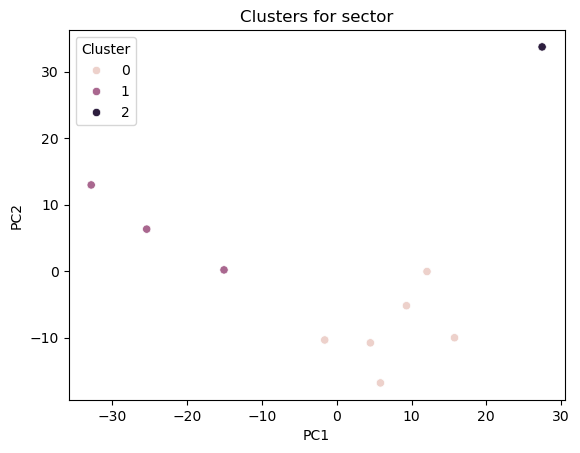

Clusters for sector_twins:
     ETF  Cluster        PC1        PC2
0    XLF        6  14.384474 -10.127219
1    VFH        6  12.968992  -9.656108
2    XLK        4   5.119601 -16.710528
3    VGT        4   6.270146 -17.835264
4    XLY        8   3.546470 -10.706931
5    VCR        8   4.760187 -10.938441
6    XLP        0 -15.627640   1.430270
7    VDC        0 -14.762131   1.338628
8    XLV        5  -2.661050 -10.012654
9    VHT        5  -0.962219 -11.256613
10   XLE        2  28.073428  31.809558
11   VDE        2  31.236161  33.743736
12   XLI        1   8.522066  -5.371559
13   VIS        1   9.534533  -5.616575
14   XLB        1  11.598455  -0.603602
15   VAW        1  12.946241  -0.973415
16   XLU        3 -32.761368  14.703603
17   VPU        3 -31.269383  14.273591
18  XLRE        7 -25.307464   6.997257
19   VNQ        7 -24.236790   6.667539
20   VOX        9  -1.372711  -1.155274


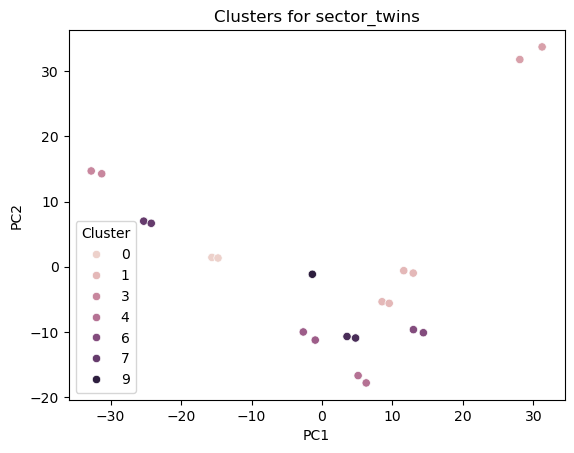

Clusters for dividend:
    ETF  Cluster        PC1        PC2
0   VYM        2   9.728966  10.530078
1   HDV        0   8.707793 -35.443129
2  SCHD        2  22.174327  19.398307
3   DVY        1 -40.611085   5.514744


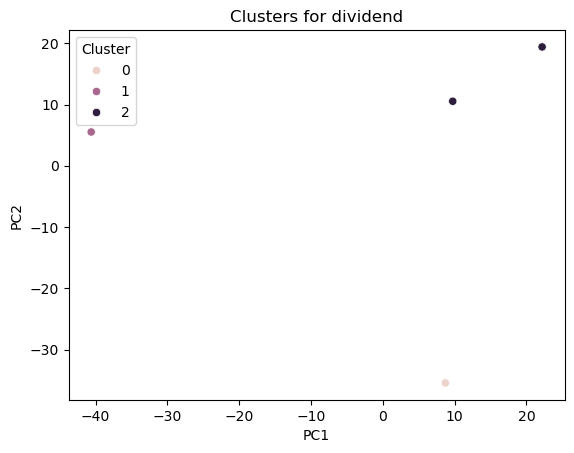

Clusters for bond:
    ETF  Cluster        PC1        PC2
0   SHY        2 -38.236998  -8.153534
1  VGSH        2 -38.746036  -8.527599
2   IEF        0  -9.151516  16.922305
3   TLH        0   5.791284  13.809299
4   TLT        1  41.751238  -7.929189
5  SPTL        1  38.592028  -6.121282


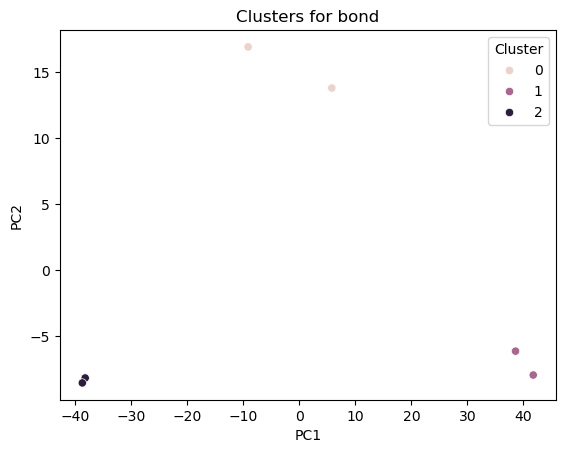

Clusters for industry_etfs:
    ETF  Cluster        PC1        PC2
0   KBE        0   4.665995  22.147580
1   XOP        1 -49.041835  -3.378245
2   IHF        0  11.590510  -2.509829
3  SOXX        0  10.805051   2.856575
4   ITA        0   9.455373  10.217820
5   IBB        0  12.524906 -29.333901


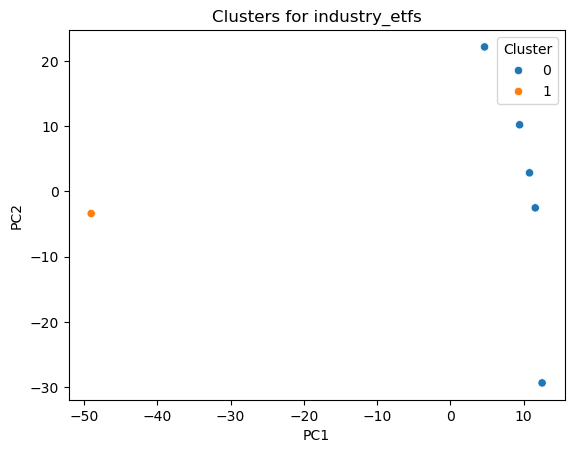

Clusters for thematic:
    ETF  Cluster        PC1        PC2
0  ARKK        2 -24.099620  14.638760
1  ARKW        2 -19.285828   9.952002
2  ROBO        0  -1.932329 -11.952476
3  BOTZ        0  -2.399292 -15.831064
4   TAN        1  25.878514  21.635655
5  ICLN        3  17.924353  -0.290343
6   LIT        0   3.914202 -18.152533


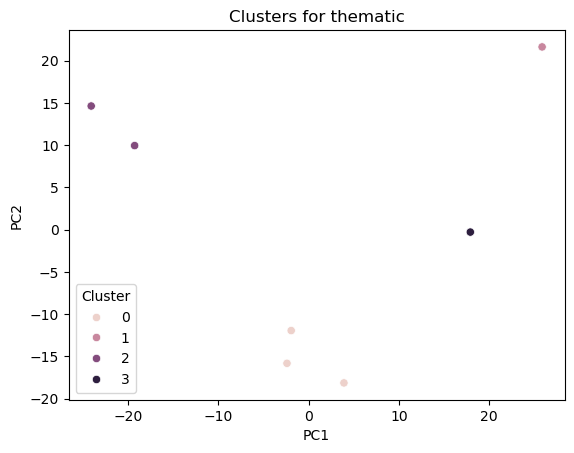

Clusters for international:
    ETF  Cluster        PC1        PC2
0   EFA        2 -13.097279  11.204845
1   VEA        2 -12.405456   9.747784
2  IEMG        0   2.990356 -14.695323
3   EEM        0   4.135491 -15.800854
4   EWJ        2 -16.363739   8.677065
5   EWU        2 -13.035340  13.645369
6   EWG        2 -13.420398  15.186358
7   FXI        3  -3.924665 -39.419706
8   EWZ        1  65.121032  11.454461


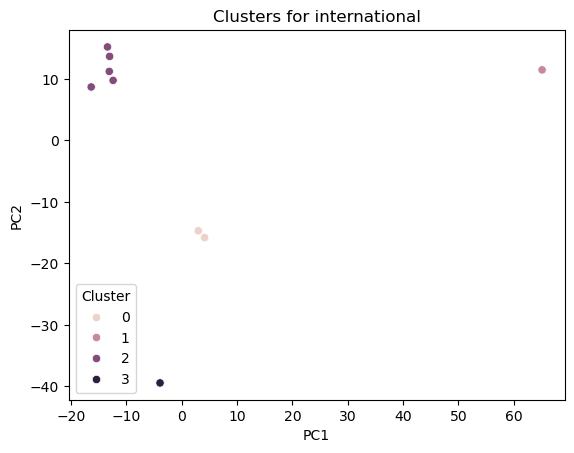

In [77]:
# k-means / PCA

for category, etfs in etf_categories.items():
    desired_etfs = [etf for etf in etfs]

    category_prices = prices[desired_etfs]

    returns = category_prices.pct_change().dropna()

    scaler = StandardScaler()
    returns_scaled = scaler.fit_transform(returns.T)

    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(returns_scaled)

    max_clusters = min(len(etfs) - 1, 10)

    best_k = 2
    best_score = -1

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(pca_components)
        score = silhouette_score(pca_components, labels)
        if score > best_score:
            best_score = score
            best_k = k

    kmeans = KMeans(n_clusters = best_k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)

    cluster_df = pd.DataFrame({
        'ETF': returns.columns,
        'Cluster': labels,
        'PC1': pca_components[:, 0],
        'PC2': pca_components[:, 1]
    })

    print(f"Clusters for {category}:")
    print(cluster_df)

    sns.scatterplot(data=cluster_df, x='PC1', y='PC2', hue='Cluster')
    plt.title(f"Clusters for {category}")
    plt.show()

    cluster_df = cluster_df.sort_values(by='Cluster')